In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

#Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

## 1. Visualization

### 1.1 Wave and spectrogram

In [101]:
train_audio_path = 'C:/Users/o/Desktop/Speech/train/train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

In [102]:
samples=samples.astype(float)

we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [103]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3)) #320
    noverlap = int(round(step_size * sample_rate / 1e3)) #160
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg, #length of segment
                                    noverlap=noverlap, #number of points to overlap between segment
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5,0,'Seconds')

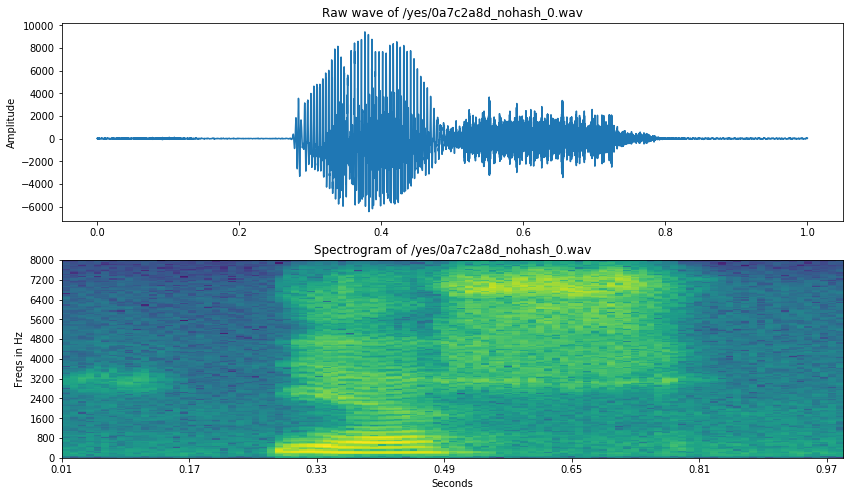

In [104]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good mean and std!)

In [105]:
mean = np.mean(spectrogram,axis=0)
std = np.std(spectrogram,axis=0)
spectrogram = (spectrogram-mean) / std

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

### 1.2 MFCC

If you want to get to know some details about MFCC take a look at this great tutorial. MFCC explained You can see, that it is well prepared to imitate human hearing properties

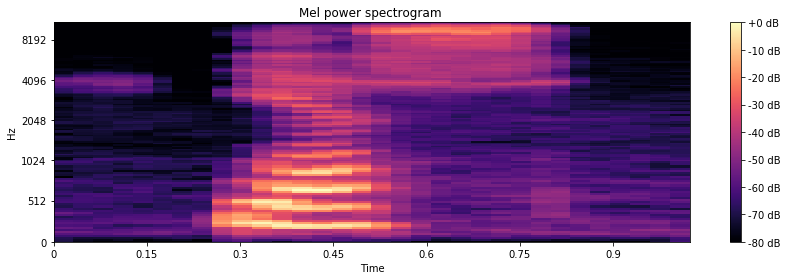

In [106]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128) #128,32

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

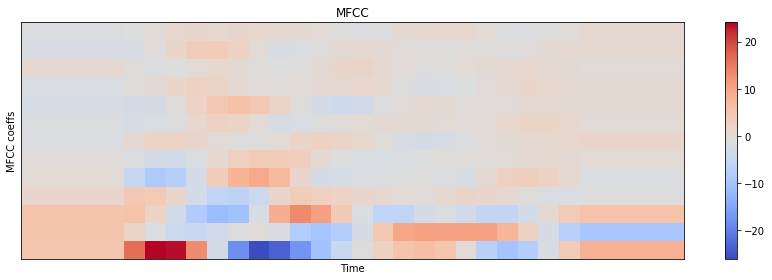

In [107]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

#Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a

It is your decision which to choose!

## 1.3 Spectrogram in 3d

By the way, times change, and the tools change. Have you ever seen spectrogram in 3d?

In [108]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies', range=freqs),
    xaxis = dict(title='Time', range=times),
    zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

ValueError: 
    Invalid value of type 'numpy.ndarray' received for the 'range' property of layout.scene.xaxis
        Received value: array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

    The 'range' property is an info array that may be specified as:

    * a list or tuple of 2 elements where:
(0) The 'range[0]' property accepts values of any type
(1) The 'range[1]' property accepts values of any type

In [114]:
ipd.Audio(samples,rate=sample_rate)

I consider that some VAD (Voice Activity Detection) will be really useful here. Although the words are short, there is a lot of silence in them. A decent VAD can reduce training size a lot, accelerating training speed significantly. Let's cut a bit of the file from the beginning and from the end. and listen to it again (based on a plot above, we take from 4000 to 13000):

In [117]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

We can agree that the entire word can be heard. It is impossible to cut all the files manually and do this basing on the simple plot. But you can use for example webrtcvad package to have a good VAD.

Let's plot it again, together with guessed alignment of 'y' 'e' 's' graphems

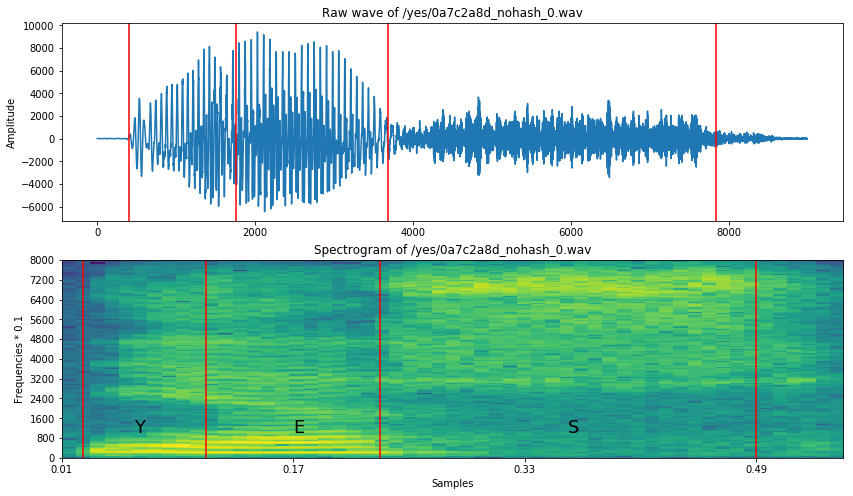

In [118]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16]) #50*16 = 800
ax2.set_xticks(times[::16]) #0.1*16 = 0.16
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## 1.5. Resampling - dimensionality reduction

Another way to reduce the dimensionality of our data is to resample recordings.

You can hear that the recording don't sound very natural, because they are sampled with 16k frequency, and we usually hear much more. However, the most speech related frequencies are presented in smaller band. That's why you can still understand another person talking to the telephone, where GSM signal is sampled to 8000 Hz.

Summarizing, we could resample our dataset to 8k. We will discard some information that shouldn't be important, and we'll reduce size of the data.

We have to remember that it can be risky, because this is a competition, and sometimes very small difference in performance wins, so we don't want to lost anything. On the other hand, first experiments can be done much faster with smaller training size.

We'll need to calculate FFT (Fast Fourier Transform). Definition:

In [159]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [160]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate=8000
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))
#resample : resample x to num samples using Fourier method along the given axis

In [161]:
ipd.Audio(samples, rate = sample_rate)

In [162]:
ipd.Audio(resampled, rate=new_sample_rate)

Almost no difference!

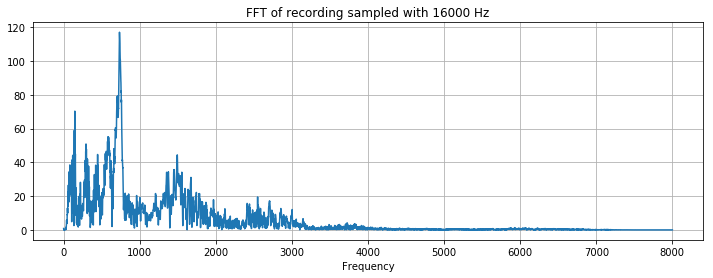

In [163]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

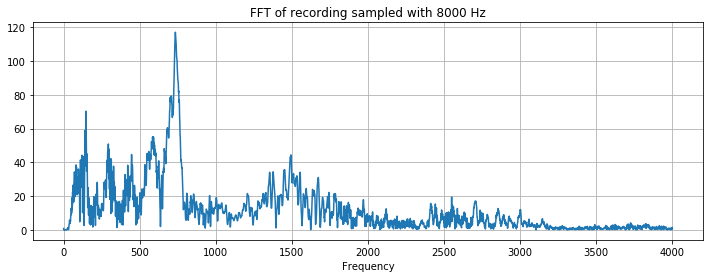

In [177]:
xf, vals = custom_fft(resampled,new_sample_rate)
plt.figure(figsize=(12,4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

## 1.6 Features extraction steps

I would propose the feature extraction algorithm like that:
    1. Resampling
    2. VAD(voice activity detection)
    3. Maybe padding with 0 to make signals be equal length
    4. Log spectrogram(or MFCC, or PLP)
    5. Features normalization with mean and std
    6. Stacking of a given number of frames to get temporal information
It's a pity it can't be done in notebook. It has not much sense to write things from zero, and everything is ready to take, but in packages, that can not be imported in Kernels.
    

## 2. Dataset Investigation

## 2.1 Number of records

In [178]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path,f))]
dirs.sort()
print('Number of labels : ' + str(len(dirs)))

Number of labels : 31


In [189]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

In [197]:
data = [go.Histogram(x=dirs, y=number_of_recordings)]
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
layout
#py.iplot(go.Figure(data=[trace], layout=layout))

Layout({
    'title': 'Number of recordings in given label',
    'xaxis': {'title': 'Words'},
    'yaxis': {'title': 'Number of recordings'}
})

## 2.2 Deeper into recordings

There's a very important fact. Recordings come from very different sources. As far as I can tell, some of them can come from mobile GSM channel.

Nevertheless, it is extremely important to split the dataset in a way that one speaker doesn't occur in both train and test sets. Just take a look and listen to this two examlpes:

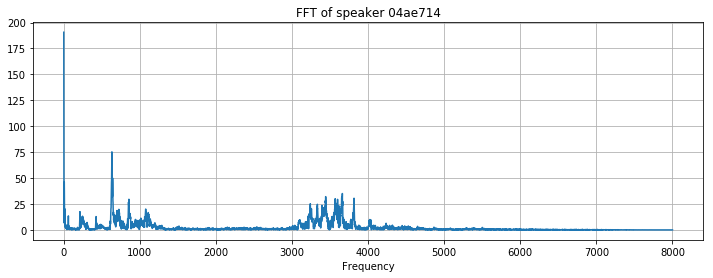

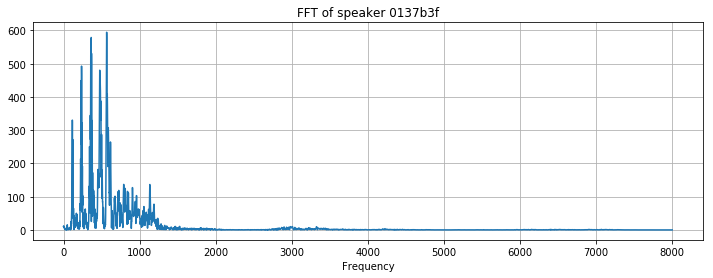

In [198]:
filenames = ['on/004ae714_nohash_0.wav','one/0137b3f4_nohash_0.wav']
for filename in filenames:
    samples_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12,4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show()

In [200]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [201]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 0137b3f


There are also recordings with some weird silence (some compression?):

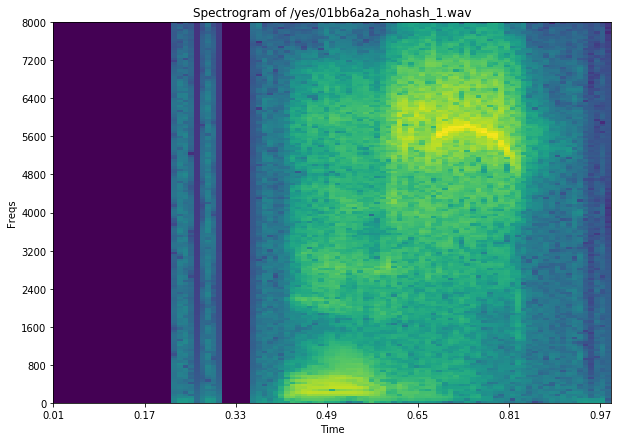

In [202]:
filename = '/yes/01bb6a2a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

It means, that we have to prevent overfitting to the very specific acoustical environments.

## 2.3 Recordings length

Find all the files have 1 second duration:

In [211]:
num_of_shorter = 0
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second : ' + str(num_of_shorter))

C:\Users\o\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\o\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\o\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\o\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second : 6469


That's suprising, and there is a lot of them. We can pad them with zeros.

## 2.4 Mean spectrograms and FFT

['004ae714_nohash_0.wav',
 '004ae714_nohash_1.wav',
 '00f0204f_nohash_0.wav',
 '00f0204f_nohash_1.wav',
 '00f0204f_nohash_2.wav',
 '012c8314_nohash_0.wav',
 '0132a06d_nohash_0.wav',
 '0132a06d_nohash_1.wav',
 '0132a06d_nohash_2.wav',
 '0132a06d_nohash_3.wav',
 '0132a06d_nohash_4.wav',
 '0135f3f2_nohash_0.wav',
 '0135f3f2_nohash_1.wav',
 '0137b3f4_nohash_0.wav',
 '0137b3f4_nohash_1.wav',
 '0137b3f4_nohash_2.wav',
 '0137b3f4_nohash_3.wav',
 '0137b3f4_nohash_4.wav',
 '01648c51_nohash_0.wav',
 '01648c51_nohash_1.wav',
 '016e2c6d_nohash_0.wav',
 '019fa366_nohash_0.wav',
 '019fa366_nohash_1.wav',
 '01bb6a2a_nohash_0.wav',
 '01bb6a2a_nohash_1.wav',
 '01bb6a2a_nohash_2.wav',
 '01bb6a2a_nohash_3.wav',
 '01bb6a2a_nohash_4.wav',
 '01bcfc0c_nohash_0.wav',
 '01d22d03_nohash_0.wav',
 '01d22d03_nohash_1.wav',
 '01d22d03_nohash_2.wav',
 '022cd682_nohash_0.wav',
 '023808be_nohash_0.wav',
 '023a61ad_nohash_0.wav',
 '023a61ad_nohash_1.wav',
 '023a61ad_nohash_2.wav',
 '026290a7_nohash_0.wav',
 '02fcd241_n

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


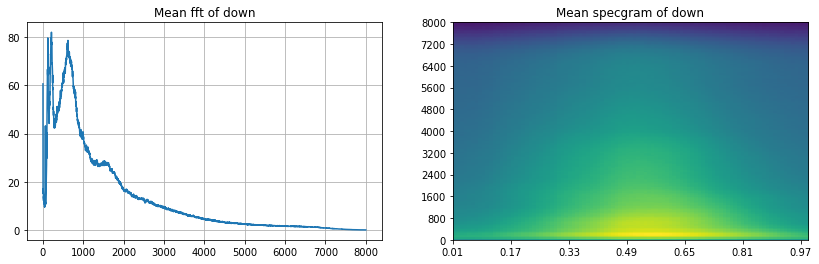

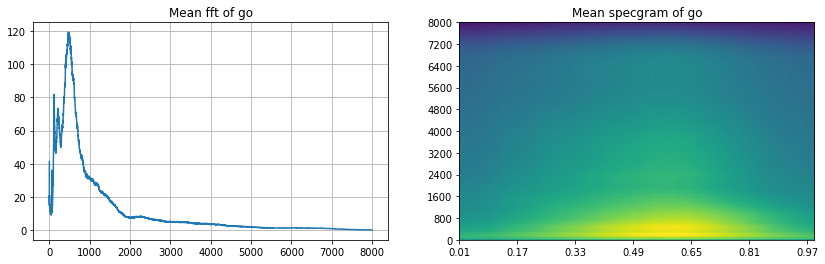

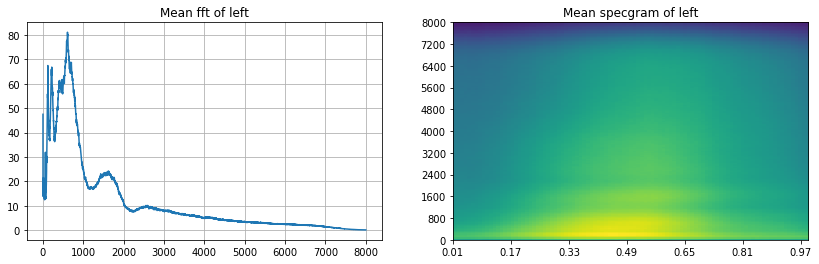

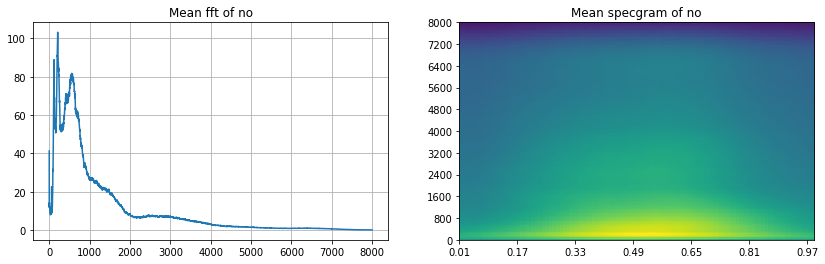

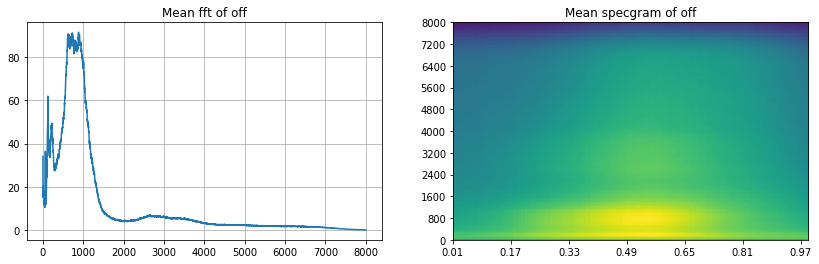

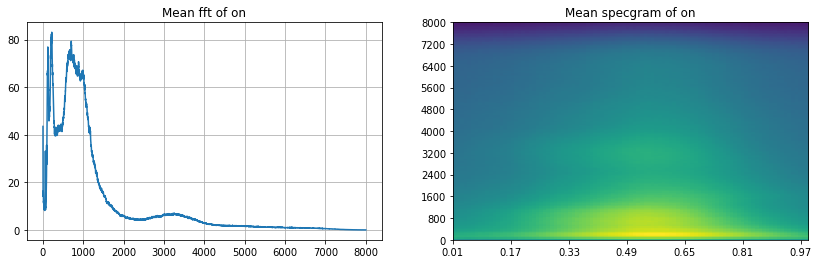

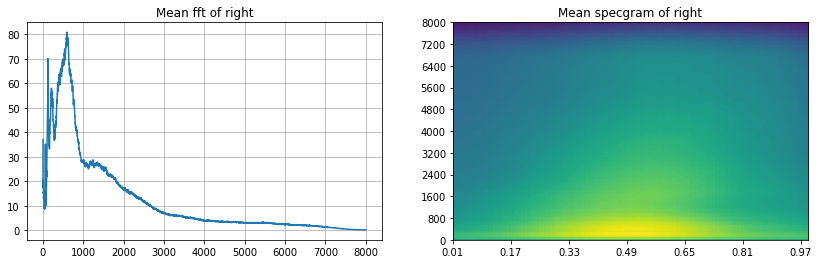

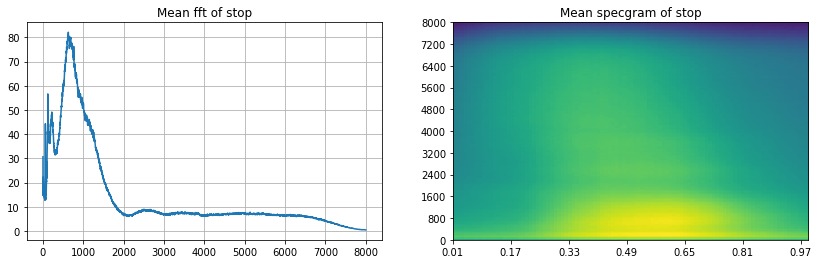

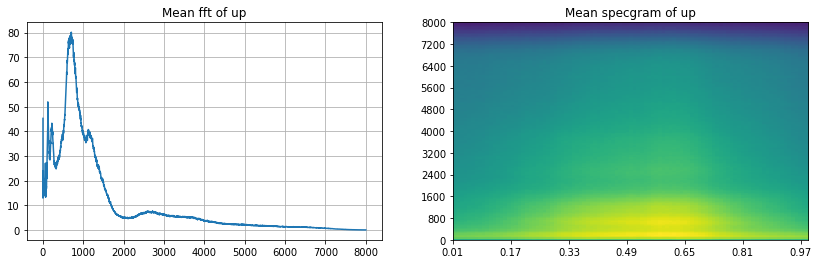

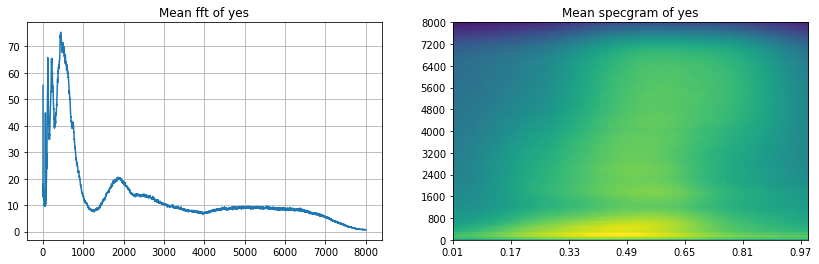

In [212]:
to_keep = 'yes no up down left right on off stop go'.split()
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

## 2.5 Gaussian Mixtures Modeling

We can see that mean FFT looks different for every word. We could model each FFT with a mixture of Gaussian distributions. Some of them however, look almost identical on FFT, like stop and up... But wait, they are still distinguishable when we look at spectrograms! High frequencies are earlier than low at the beginning of stop (probably s).

That's why temporal component is also necessary. There is a Kaldi library, that can model words (or smaller parts of words) with GMMs and model temporal dependencies with Hidden Markov Models.

We could use simple GMMs for words to check what can we model and how hard it is to distinguish the words. We can use Scikit-learn for that, however it is not straightforward and lasts very long here, so I abandon this idea for now.

## 2.6 Frequency components across the words

In [214]:
def violinplot_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

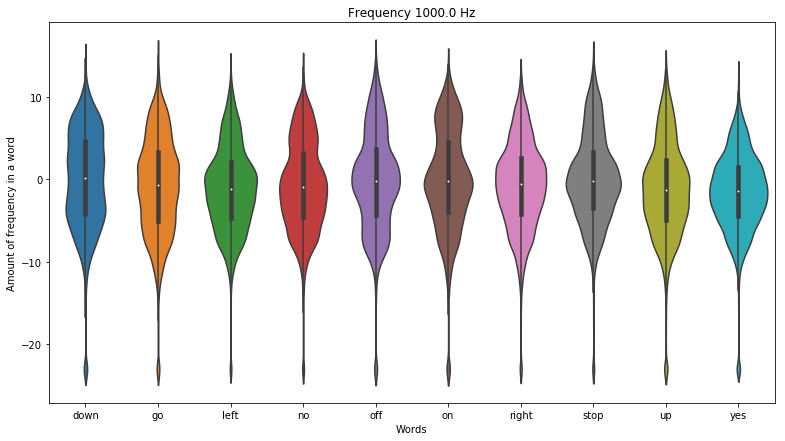

In [215]:
violinplot_frequency(dirs, 20)

## 2.7 Anomaly detection

We should check if there are any recordings that somehow stand out from the rest. We can lower the dimensionality of the dataset and interactively check for any anomaly. We'll use PCA for dimensionality reduction:

In [216]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

In [221]:
fft_all = np.array(fft_all)

#Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all,axis=0)

In [222]:
#Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

In [223]:
def interactive_3d_plot(data,names):
    scatt = go.Scatter3d(x=data[:,0], y=data[:,1], z=data[:,2], mode='markers',text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout = layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all,names)

C:\Users\o\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


